# Colab Configs

In [3]:
%cd drive/My\ Drive/Side \Projects/Upwork/Unsupervised_Topic_Classification

[Errno 2] No such file or directory: 'drive/My Drive/Side Projects/Upwork/Unsupervised_Topic_Classification'
/content/drive/My Drive/Side Projects/Upwork/Unsupervised_Topic_Classification


In [5]:
from google.colab import auth
auth.authenticate_user()

# Imports

In [32]:
!pip -q install jsonlines emoji rake_nltk timeout_decorator pyLDAvis nmslib tensorflow-transform

     |████████████████████████████████| 327kB 4.9MB/s 
     |████████████████████████████████| 2.0MB 11.6MB/s 
     |████████████████████████████████| 3.4MB 37.8MB/s 
     |████████████████████████████████| 112kB 51.5MB/s 
     |████████████████████████████████| 63.2MB 124kB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 153kB 50.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 1.4MB 47.3MB/s 
     |████████████████████████████████| 440kB 43.4MB/s 
     |████████████████████████████████| 174kB 53.5MB/s 
     |████████████████████████████████| 184kB 49.8MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 153kB 54.4MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 215kB 51.7MB/s 
     |████████████████████████████████| 235kB 38.6MB/s 
 

In [33]:
import os, sys, json, csv
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
from bs4 import BeautifulSoup
import re
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import emoji
from nltk.corpus import stopwords
import string
from rake_nltk import Rake
import nltk
from lxml import html, etree
from timeout_decorator import timeout, TimeoutError
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from gensim import models, corpora
from scipy.special import softmax
np.set_printoptions(precision=5)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import gspread
from oauth2client.client import GoogleCredentials
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim
import spacy
import pyLDAvis
import pyLDAvis.gensim 
import tensorflow_hub as hub
import nmslib
import tensorflow_transform as tft

nltk.download('stopwords')

!python -c "import nltk; nltk.download('stopwords')"
!python -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


#Utils

In [8]:
sw= STOPWORDS | set(stopwords.words('english')) | {"you'", "your'", 'aka', 'log', 'in', 'login', 'i', 'forgot', 'my', 'password', 'sign', 'up', 'home', 'contact', 'us', 'related', 'faq', 'terms', 'use', 'terms'}
# "'", '!', '&', ',', '.', 

In [9]:
def html2txt(html_doc):
    html_doc = re.sub(r'<script[\s\S]*?<\/script>|<style[\s\S]*?</style>', ' ', html_doc)
    # soup = BeautifulSoup(html)
    # for s in soup(['script', 'style']):
    #     s.decompose()
    # return ' '.join(soup.stripped_strings)
    try:
        text = html.document_fromstring(html_doc)
        return text.text_content()
    except:
        text = etree.fromstring(html_doc)
        return ' '.join(e.text for e in doc.xpath('//Text'))
    finally:
        soup = BeautifulSoup(html_doc)
        for s in soup(['script', 'style']):
            s.decompose()
        return ' '.join(soup.stripped_strings)


In [10]:
def html2df(data_path):
    data = {'id': [], 'text': []}
    for file in tqdm(os.listdir(data_path)):
        if not file.endswith('.html'):
            continue
        with open(os.path.join(data_path, file), encoding="utf-8", errors='ignore') as f:
            html_doc = f.read()
        try:
            text = html2txt(html_doc)
        except:
            print(file)
            return
        data['id'].append(file.split('.html')[0])
        data['text'].append(text)
    return pd.DataFrame(data)

In [11]:
@timeout(seconds=5)
def text_normalizer(text):
    try:
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI).strip()
        # punc = ''.join({"""‘،؟.,":؛!’‘““.©–,’.”"""} | {string.punctuation})
        # text = re.sub(r'[{0}]+'.format(punc), ' ', text)
        text = re.sub(r'(\n)\1+', r'\1', text)
        text = re.sub(r'(.)\1+', r'\1\1', text)
        url_pattern = url_pattern = r"(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»\"\"'']))"
        text = re.sub(url_pattern, ' ', text)
        email_pattern = r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+'
        text = re.sub(email_pattern, ' ', text)
        date_pattern_1 = r'[٠١٢٣٤٥٦٧٨٩0-9]{1,2} *[/.-] *[٠١٢٣٤٥٦٧٨٩0-9]{1,2} *[/.-]\ *[٠١٢٣٤٥٦٧٨٩0-9]{4}'
        date_pattern_2 = r'[٠١٢٣٤٥٦٧٨٩0-9]{4} *[/.-] *[٠١٢٣٤٥٦٧٨٩0-9]{1,2} *[/.-]\ *[٠١٢٣٤٥٦٧٨٩0-9]{1,2}'
        text = re.sub(date_pattern_1, ' ', text).strip()
        text = re.sub(date_pattern_2, ' ', text).strip()
        text = re.sub(r'@[a-zA-Z0-9-._]+', ' ', text)
        text = text.lower()
        text = re.sub('\t', ' ', text)
        # sw= STOPWORDS | set(stopwords.words('english')) | {'aka', 'log', 'in', 'login', 'i', 'forgot', 'my', 'password', 'sign', 'up', 'home', 'contact', 'us', 'related', 'faq', 'terms', 'use', 'terms'}
        # text = ' '.join([w for w in text.split(" ") if w not in sw])
        text = re.sub(r'[^a-zA-Z?.!:,& \n)(\}\{\-\[\];\'"]+', ' ', text)
        # text = ' '.join([w for w in text.split(" ") if len(w) > 2 and len(w) < 30])
        text = re.sub(r'(\n)\1+', r'\1', text)
        text = re.sub(r'(.)\1+', r'\1\1', text)
        text = re.sub(r'\b\w{1,2}\b|\b\w{30,}\b', '', text)
        
        # text = ' '.join(text.split())
        return text.strip()
    except:
        np.nan

In [12]:
def plot_word_cloud_from_frequencies(docs, return_freqs=False):
    freq_counter = Counter()

    for i in tqdm(docs):
        freq_counter.update([i for i in i.split() if len(i) > 2 and i not in sw])
    
    cloud = WordCloud(stopwords=sw, background_color='black', width=1600, height=800).generate_from_frequencies(freq_counter)
    plt.figure(figsize=(15, 15), facecolor='k')
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
    if return_freqs:
        return freq_counter.most_common()

In [13]:
def create_gensim_tfidf(docs, saving_dir='models/'):
    stemmer = PorterStemmer() # Stemmer for reducing terms to root form
    stemmed_corpus = []       # For storing the stemmed tokens
    original_corpus = []      # For storing the non-stemmed tokens

    for contents in tqdm(docs):                # Iterate over the files 
        tokens = word_tokenize(contents)     # Extract tokens
        stemmed = [stemmer.stem(token) for token in tokens] # Stem tokens
        stemmed_corpus.append(stemmed)    # Store stemmed document
        original_corpus.append(tokens)    # Store original document
    
    dictionary = Dictionary(stemmed_corpus) # Build the dictionary

    # Convert to vector corpus
    corpus = [dictionary.doc2bow(text) for text in tqdm(stemmed_corpus)]

    # Build TF-IDF model
    tfidf_model = TfidfModel(corpus)

    print("Saving model, dictionary and corpus...")
    tfidf_model.save(os.path.join(saving_dir, "gensim_tfidf_model.model"))
    dictionary.save(os.path.join(saving_dir, "gensim_tfidf_dictionary.dic"))
    corpora.MmCorpus.serialize(os.path.join(saving_dir, 'gensim_tfidf_corpuse.mm', vectors))
    print("Done")

    return tfidf_model, dictionary, corpus


In [14]:
def load_gensim_tfidf(dir='models/'):
    gensim_tfidf_model = models.TfidfModel.load(os.path.join(dir, "gensim_tfidf_model.model"))
    gensim_tfidf_dictionary = corpora.Dictionary.load(os.path.join(dir, 'gensim_tfidf_dictionary.dic'))
    gensim_tfidf_corpuse = corpora.MmCorpus(os.path.join(dir, 'gensim_tfidf_corpuse.mm'))

    return gensim_tfidf_model, gensim_tfidf_dictionary, gensim_tfidf_corpuse

In [15]:
def get_doc_gensim_tfidf(gensim_tfidf_model, gensim_tfidf_dictionary, gensim_tfidf_corpuse, doc):
    corpus_vector = gensim_tfidf_dictionary.doc2bow(doc.split())
    weights = gensim_tfidf_model[corpus_vector]
    weights = [(gensim_tfidf_dictionary[pair[0]], pair[1]) for pair in weights]
    weights = {i[0]: i[1] for i in weights if i[0] not in sw}
    sorted_weights = sorted(weights.items(), key=lambda item: item[1], reverse=True)

    return weights, sorted_weights


In [16]:
def plot_word_cloud_from_tfidf(tfidf_dict, stop_words=sw):
    wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stop_words)

    wc.generate_from_frequencies(tfidf_dict)

    # Save the could to a file

    # wc.to_file("word_cloud.png")
    plt.figure(figsize=(15, 15), facecolor='k')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [17]:
def normalize_rake_results(results, is_word_degree=0):
    x = np.array([i[is_word_degree] for i in results])

    sm = (x-min(x))/(max(x)-min(x))

    return sorted([(w[not is_word_degree], np.round(s, 10)) for w, s in zip(results, sm)], key=lambda x: x[1], reverse=True)

In [18]:
r = Rake(language='english', punctuations='?.!:,& \n)(\}\{\-\[\];\'"', stopwords=sw)
def rake_extract_keywords(doc):
    r.extract_keywords_from_text(doc)
    # To get keyword phrases ranked highest to lowest.
    return r.get_ranked_phrases_with_scores(), sorted(r.get_word_degrees().items(), key=lambda item: item[1], reverse=True)


<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<input>:1: DeprecationWarning: invalid escape sequence \}
<ipython-input-18-aa54501365d1>:1: DeprecationWarning: invalid escape sequence \}
  r = Rake(language='english', punctuations='?.!:,& \n)(\}\{\-\[\];\'"', stopwords=sw)


In [19]:
def plot_word_cloud_from_rake(keywords, is_word_degree=0):
    r = {i[not is_word_degree]: i[is_word_degree] for i in keywords}
    if not is_word_degree:
        r = {k: v for k, v in r.items() if len(k.split()) > 1}
    plot_word_cloud_from_tfidf(r)


In [20]:
def gensim_tokenizer(docs):
    for doc in tqdm(docs):
        yield(simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations

In [21]:
def create_bigrams_limatized(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load('en', disable=['parser', 'ner'])
    print("Tokenizing...")
    toknized_data = list(gensim_tokenizer(docs))
    print("Building Bi-Gram Model...")
    phrases = gensim.models.Phrases(toknized_data, min_count=5, threshold=100)
    bigram_model = gensim.models.phrases.Phraser(phrases)
    print("Saving the Bi-Gram Model...")
    bigram_model.save("models/bigram_model.pkl")

    output = []

    print("Construct Bi-Grams and Lematizing...")
    for doc in tqdm(toknized_data):
        bg = bigram_model[doc]
        doc_ = nlp(" ".join(bg))
        output.append([token.lemma_ for token in doc_ if token.pos_ in allowed_postags])
    
    print("Saving the lematized bi-gram data...")
    with open("data/data_bigrams_limatized.csv","w") as f:
        wr = csv.writer(f)
        wr.writerows(output)
    
    return output

In [89]:
def embed_text(data):
    global embed
    if embed is None:
        embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
    embedding = embed(data)
    return embedding

In [84]:
def build_index(X):
    nmslib_index = nmslib.init(space='l2', method='sw-graph')
    #nmslib_index = nmslib.init(method='sw-graph', space='angulardist')
    #nmslib_index = nmslib.init(method='hnsw', space='l1')
    nmslib_index.addDataPointBatch(ids=np.arange(X.shape[0], dtype=np.int32), data=X)
    nmslib_index.createIndex({}, print_progress=True)
    return nmslib_index

In [85]:
def search(text, nmslib_index, k=1):
    query = embed_text([text])
    idxs, dists = nmslib_index.knnQuery(query, k=k)

    return idxs, dists

In [92]:
def classify_docs(docs, nmslib_index, k=1):
    themes = []
    categories = []
    topics = []
    for doc in docs:
        idx, cs = search(doc, nmslib_index, k=k)
        themes.append(taxo['theme'][idx])
        categories.append(taxo['category'][idx])
        topics.append(taxo['topic'][idx])

    return themes, categories, topics

# Extract Data

In [ ]:
!tar -C /content -zxf data/crawled_pages.tar.gz

In [ ]:
df = html2df(data_path='/content/output')

In [ ]:
df

,id,text
0,0227167e47c81d58d08b15cc171e8867.html,Doodle - Make meetings happen
1,8608f166ca1db22a3c7a06a5a7fab578.html,What is another word for prevailing? | Prevail...
2,0ac532bfb2b7ccb8adcf5886aeaea331.html,"Xbox Series X backward compatibility adds HDR,..."
3,8dad0c000622c3d8784886ae0a2a6101.html,Rivals keen to play on despite holding upper h...
4,e9e9354bb40a38eb116d5a9ebe5f7b2d.html,Outlook – free personal email and calendar fro...
...,...,...
41237,27ff0cbc35804fa5d77f521caf10019e.html,Steven Spielberg | Investing Magazine Investin...
41238,5b805e0d8b1a3d12bdba623ed96f7bef.html,"If you were buying a solid state drive, which ..."
41239,ec4901a9b553b40777ffe7aea8673eef.html,Here’s what counts as a non-essential shop - a...
41240,25421ef3c86291613b6042fcd322ce5e.html,Seaborn - Histogram - Tutorialspoint Home Jobs...


In [ ]:
df[df.isnull().T.any().T].reset_index(drop=True)#.to_csv("NULLS.csv", index=False)

,id,text


In [ ]:
df = df.dropna().reset_index(drop=True)

In [47]:
df.to_csv("data/pages_datframe.csv", index=False)

# Load Data

In [22]:
df = pd.read_csv("data/pages_datframe.csv")

In [23]:
df

,id,text,normalized_text
0,778c142480c3c3c08f103fe6b44a0599,Teamfighting - Ривен Build Guide - 16 minutes ...,teamfighting - build guide - minutes - probu...
1,40ed3cf51a1400fc56d1ad4fb3af8109,Outlook – free personal email and calendar fro...,outlook free personal email and calendar from...
2,48019f717c658a538b8b699425c739c8,Formula One - Participating Countries - Tutori...,formula one - participating countries - tutori...
3,757701ae30b5e10b67b1c842cb0c0e0a,HP Pavilion x360 (14-inch) - Full Review and B...,pavilion ( -inch) - full review and benchmar...
4,ef76a5942e2a9b1aeabdfec48eb74edb,ValidationMessageFor in ASP.NET MVC Follow Us ...,validationmessagefor asp.net mvc follow pyth...
...,...,...,...
41082,0e8a28d8b94bccbdb6d8fadf6b6ce942,MasterChef Australia S12E36 - MasterChef Austr...,masterchef australia - masterchef australia...
41083,e089a1ff537fcf810d9bd8f1cec2a2e5,The Sims 4 Plant Locations (Where to Find) All...,the sims plant locations (where find) all gu...
41084,a4470ad28aabc391262eacc8447a62f2,Lockdown restrictions lifted before experts re...,lockdown restrictions lifted before experts re...
41085,aaf37841232a8b1131723065bc6419f4,Tureng - akin - Turkish English Dictionary Tur...,tureng - akin - turkish english dictionary tur...


In [24]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('intent-data_poc_taxonomy_sample - Taxonomy').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
taxo = pd.DataFrame.from_records(rows, columns=['theme', 'category', 'topic', 'description'])
taxo = taxo.iloc[1:].reset_index(drop=True)

In [25]:
taxo

,theme,category,topic,description
0,BioTech,AgriTech,Botany,Botany is the science of plant life and a bran...
1,BioTech,AgriTech,Genetic Engineering,"Genetic engineering, also called genetic modif..."
2,BioTech,AgriTech,Herbicide Tolerance,Herbicide tolerance consists of chemical herbi...
3,BioTech,AgriTech,Insect Resistance,Insect resistance is a trait that increases a ...
4,BioTech,AgriTech,Microorganisms,A microorganism or microbe is a microscopic or...
...,...,...,...,...
6599,Technology,Wireless,Wireless Messaging,Wireless messaging is another phrase for text ...
6600,Technology,Wireless,Wireless Networking,Wireless networking is a method by which homes...
6601,Technology,Wireless,Wireless Printing,Wireless printing is a printer connected or a ...
6602,Technology,Wireless,Wireless Security,Wireless security is the prevention of unautho...


# Clean Data

In [ ]:
df['normalized_text'] = df['text'].progress_apply(text_normalizer)

# Keywords Extraction

In [ ]:
df

,id,text,normalized_text
0,778c142480c3c3c08f103fe6b44a0599.html,Teamfighting - Ривен Build Guide - 16 minutes ...,teamfighting - build guide - minutes - probu...
1,40ed3cf51a1400fc56d1ad4fb3af8109.html,Outlook – free personal email and calendar fro...,outlook free personal email and calendar from...
2,48019f717c658a538b8b699425c739c8.html,Formula One - Participating Countries - Tutori...,formula one - participating countries - tutori...
3,757701ae30b5e10b67b1c842cb0c0e0a.html,HP Pavilion x360 (14-inch) - Full Review and B...,pavilion ( -inch) - full review and benchmar...
4,ef76a5942e2a9b1aeabdfec48eb74edb.html,ValidationMessageFor in ASP.NET MVC Follow Us ...,validationmessagefor asp.net mvc follow pyth...
...,...,...,...
41082,0e8a28d8b94bccbdb6d8fadf6b6ce942.html,MasterChef Australia S12E36 - MasterChef Austr...,masterchef australia - masterchef australia...
41083,e089a1ff537fcf810d9bd8f1cec2a2e5.html,The Sims 4 Plant Locations (Where to Find) All...,the sims plant locations (where find) all gu...
41084,a4470ad28aabc391262eacc8447a62f2.html,Lockdown restrictions lifted before experts re...,lockdown restrictions lifted before experts re...
41085,aaf37841232a8b1131723065bc6419f4.html,Tureng - akin - Turkish English Dictionary Tur...,tureng - akin - turkish english dictionary tur...



---

Word Cloud, based on word frequency, for the whole web pages in the dataset.

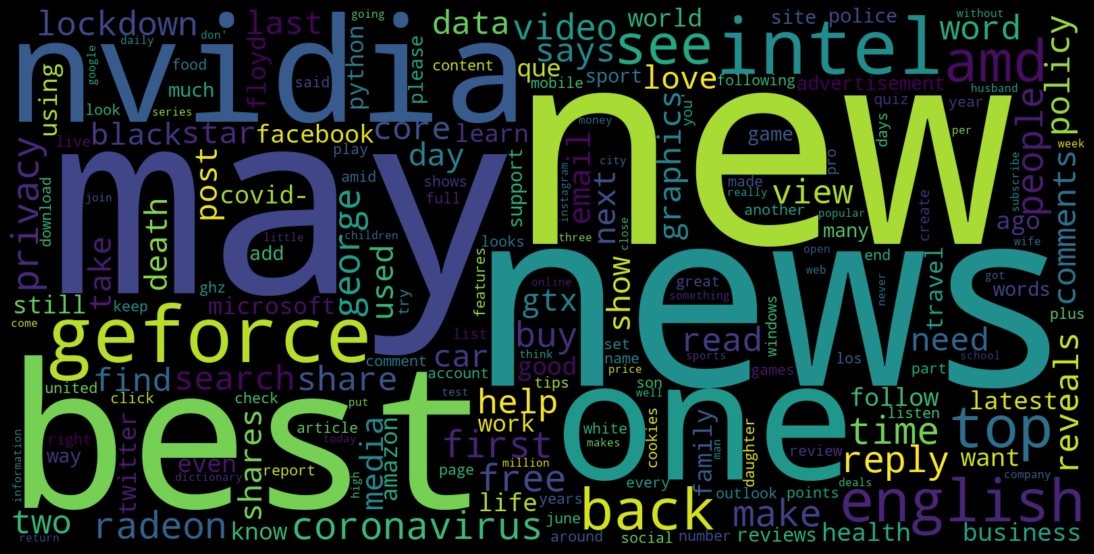

In [76]:
plot_word_cloud_from_frequencies(df['normalized_text'])


---

Word Cloud, based on word frequency, for the second web page of id = `40ed3cf51a1400fc56d1ad4fb3af8109`

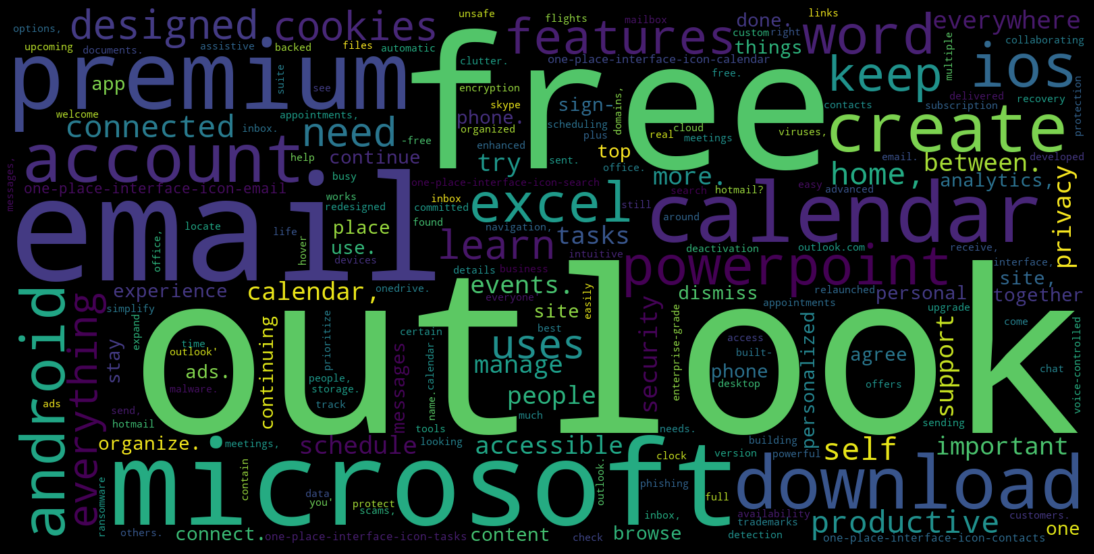

In [79]:
plot_word_cloud_from_frequencies([df['normalized_text'][1]])

---
## Keywords Extraction using TFIDF Model

In [80]:
gensim_tfidf_model, gensim_tfidf_dictionary, gensim_tfidf_corpuse = load_gensim_tfidf()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [116]:
tfidf_dict, sorted_tfidf_scores = get_doc_gensim_tfidf(gensim_tfidf_model, gensim_tfidf_dictionary, gensim_tfidf_corpuse, df['normalized_text'][1])

---
Top 15 Words extracted by TFIDF Algorithm for the second web page of id = `40ed3cf51a1400fc56d1ad4fb3af8109`

In [117]:
sorted_tfidf_scores[:15]

[('outlook', 0.6810307365730436),
 ('events.', 0.20866649159245776),
 ('cookies', 0.20866649159245776),
 ('premium', 0.20181293217939028),
 ('microsoft', 0.1899162974826084),
 ('connected', 0.1871788538294371),
 ('more.', 0.1871788538294371),
 ('calendar', 0.1737333756464815),
 ('powerpoint', 0.1454787551988746),
 ('free', 0.12004959853922388),
 ('use.', 0.10877463421415166),
 ('important', 0.10650162479581936),
 ('done.', 0.10433324579622888),
 ('office.', 0.10433324579622888),
 ('name.', 0.10118203056443512)]

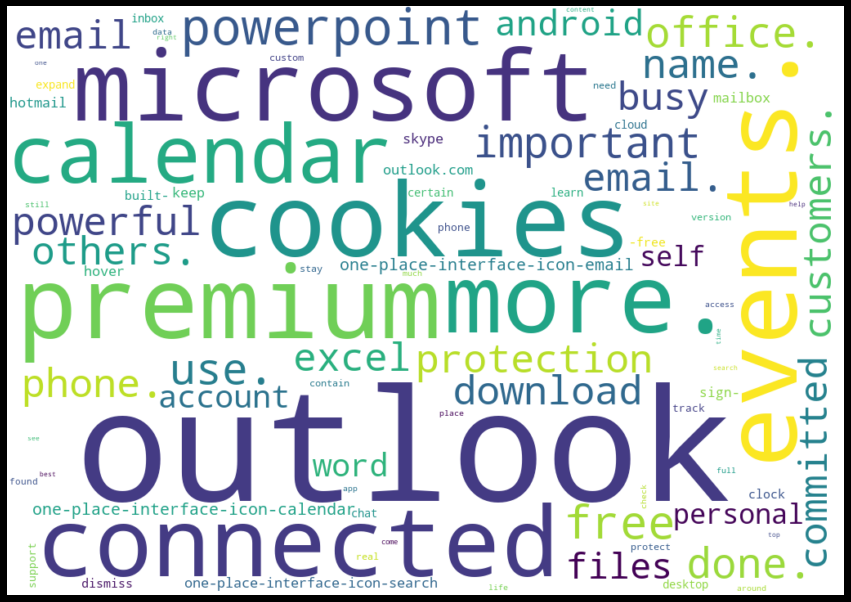

In [119]:
plot_word_cloud_from_tfidf(tfidf_dict)

---

## Keywords Extraction using RAKE Algorithm

In [198]:
keywords, word_degrees = rake_extract_keywords(df['normalized_text'][1])

Key prhases and word degrees

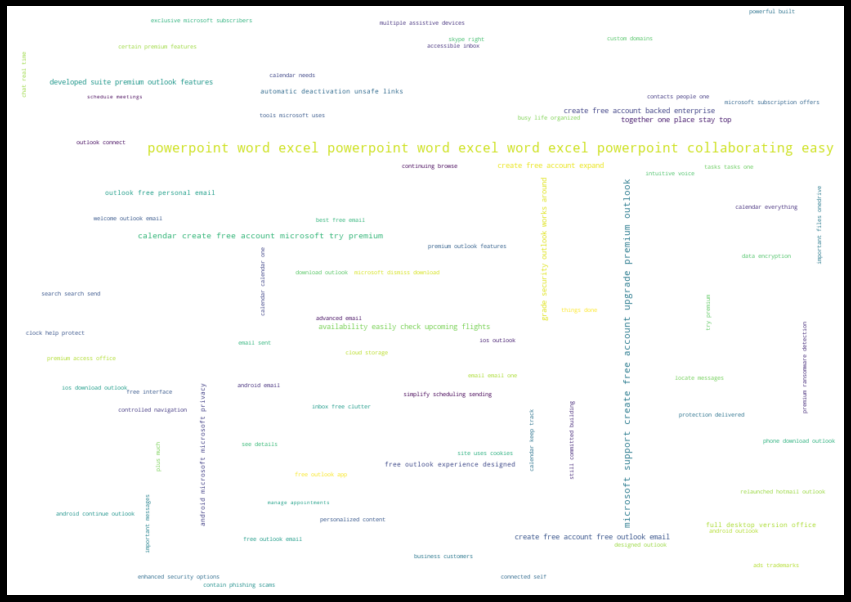

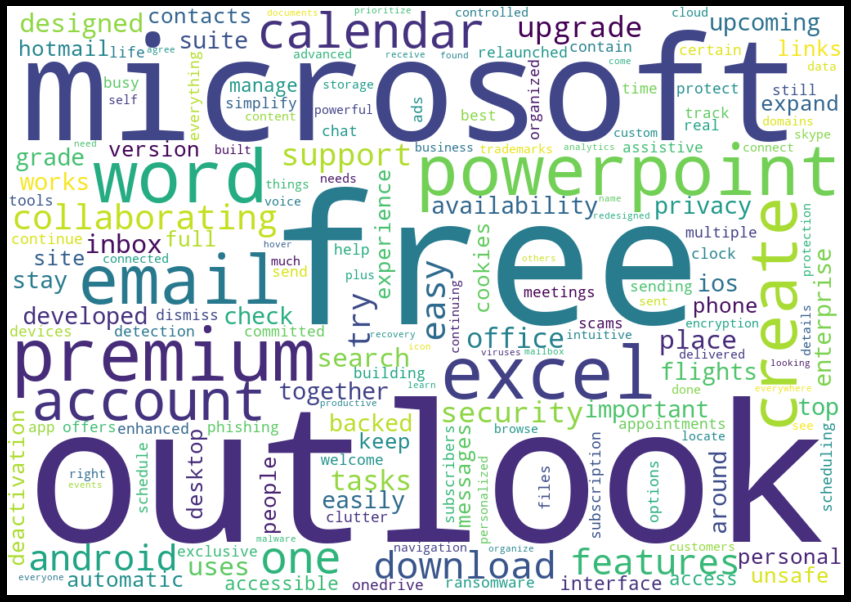

In [201]:
plot_word_cloud_from_rake(keywords)
print()
plot_word_cloud_from_rake(word_degrees, 1)

In [214]:
norm_keywords = normalize_rake_results(keywords)
norm_word_degrees = normalize_rake_results(word_degrees, is_word_degree=1)

---
Top 15 Keyphrases, Keywords, and word degrees

In [217]:
[(i[0], i[1]) for i in norm_keywords if len(i[0].split()) > 1][:15]

[('powerpoint word excel powerpoint word excel word excel powerpoint collaborating easy',
  1.0),
 ('microsoft support create free account upgrade premium outlook',
  0.4032234432),
 ('calendar create free account microsoft try premium', 0.3175824176),
 ('create free account free outlook email', 0.2634632035),
 ('create free account backed enterprise', 0.2586080586),
 ('availability easily check upcoming flights', 0.2461538462),
 ('grade security outlook works around', 0.218974359),
 ('developed suite premium outlook features', 0.2078632479),
 ('together one place stay top', 0.2051282051),
 ('create free account expand', 0.1970695971),
 ('automatic deactivation unsafe links', 0.1538461538),
 ('full desktop version office', 0.1487179487),
 ('free outlook experience designed', 0.1391208791),
 ('outlook free personal email', 0.1381884782),
 ('android microsoft microsoft privacy', 0.1256410256)]

In [218]:
[(i[0], i[1]) for i in norm_keywords if len(i[0].split()) == 1][:15]

[('word', 0.0769230769),
 ('powerpoint', 0.0769230769),
 ('excel', 0.0769230769),
 ('support', 0.0358974359),
 ('free', 0.032967033),
 ('microsoft', 0.0307692308),
 ('outlook', 0.0241025641),
 ('place', 0.0205128205),
 ('one', 0.0205128205),
 ('calendar', 0.0205128205),
 ('email', 0.0195804196),
 ('privacy', 0.0153846154),
 ('download', 0.0143589744),
 ('tasks', 0.0136752137),
 ('site', 0.0102564103)]

In [220]:
norm_word_degrees[:15]

[('outlook', 1.0),
 ('free', 0.8787878788),
 ('microsoft', 0.5303030303),
 ('premium', 0.5),
 ('word', 0.5),
 ('excel', 0.5),
 ('powerpoint', 0.5),
 ('email', 0.4696969697),
 ('create', 0.4393939394),
 ('account', 0.4393939394),
 ('calendar', 0.303030303),
 ('one', 0.2575757576),
 ('download', 0.1666666667),
 ('features', 0.1515151515),
 ('android', 0.1515151515)]

---
## Random Sample 50 web pages

In [234]:
sample_50_df = df.sample(50, random_state=1234).reset_index(drop=True)

In [240]:
sample_sorted_tfidf_scores = []
sample_key_phrases = []
sample_key_words = []
sample_word_degrees = []

for doc in sample_50_df['normalized_text']:
    _, sorted_tfidf_scores_ = get_doc_gensim_tfidf(gensim_tfidf_model, gensim_tfidf_dictionary, gensim_tfidf_corpuse, doc)
    keywords_, word_degrees_ = rake_extract_keywords(doc)
    norm_keywords_ = normalize_rake_results(keywords_)
    norm_word_degrees_ = normalize_rake_results(word_degrees_, is_word_degree=1)
    key_phrases_ = [(i[0], i[1]) for i in norm_keywords_ if len(i[0].split()) > 1]
    key_words_ = [(i[0], i[1]) for i in norm_keywords_ if len(i[0].split()) == 1]


    sample_sorted_tfidf_scores.append(sorted_tfidf_scores_[:15])
    sample_key_phrases.append(key_phrases_[:15])
    sample_key_words.append(key_words_[:15])
    sample_word_degrees.append(norm_word_degrees_[:15])


sample_50_df['top_15_tfidf_keywords'] = sample_sorted_tfidf_scores
sample_50_df['top_15_rake_keyphrases'] = sample_key_phrases
sample_50_df['top_15_rake_keypwords'] = sample_key_words
sample_50_df['top_15_rake_word_degree'] = sample_word_degrees


In [248]:
for i, row in sample_50_df.iterrows():
    print(row['top_15_tfidf_keywords'])
    print(row['top_15_rake_keyphrases'])
    print([(' '.join(set(i[0].split())), i[1]) for i in row['top_15_rake_keyphrases']])
    print(row['top_15_rake_keypwords'])
    print(row['top_15_rake_word_degree'])
    break

[('revision', 0.5259701947039404), ('emphasis', 0.49041207847223584), ('vert', 0.3615820861456464), ('english', 0.27422745443375457), ('statmt.org', 0.18080225442947953), ('request', 0.16918991723964033), ('bab.', 0.159173125524482), ('german', 0.13345079852688543), ('nacisku', 0.10553372927921534), ('akcent', 0.1012246705882147), ('nacisk', 0.1012246705882147), ('polish', 0.1008057920164143), ('open', 0.08686578179835842), ('empirical', 0.06774006825994622), ('szczeg', 0.06417361778248808)]
[('english dictionaries english polish english polish english spanish english spanish english arabic english arabic english chinese english chinese english czech english czech english danish english danish english dutch english dutch english finnish english finnish english french english french english german english german english greek english greek english hindi english hindi english hungarian english hungarian english indonesian english indonesian english italian english italian english japanes

In [244]:
sample_50_df.to_csv("data/sample_50_keywords_extraction.csv", index=False)

In [245]:
sample_50_df

,id,text,normalized_text,top_15_tfidf_keywords,top_15_rake_keyphrases,top_15_rake_keypwords,top_15_rake_word_degree
0,50aa0656e81498a621b582ab64cd8a1b,emphasis - Polish translation - bab.la English...,emphasis - polish translation - bab. english-p...,"[(revision, 0.5259701947039404), (emphasis, 0....",[(english dictionaries english polish english ...,"[(english, 0.0086913496), (expand, 0.004913419...","[(english, 1.0), (german, 0.2389564661), (span..."
1,0e314e4dfb422f4280897e5b1cb36422,Terrifying moment thug mows down victim and st...,terrifying moment thug mows down victim and st...,"[(sun, 0.38044650674820174), (coronavirus, 0.2...",[(showbiz football fabulous news sport money t...,"[(news, 0.0347092852), (football, 0.0330914796...","[(sun, 1.0), (news, 0.9496402878), (sex, 0.352..."
2,6577721f3d909e1efadf6ff148b0d08f,СПЛЕТНИК: звезды и знаменитости. Новости шоу-б...,": . - , - "" "" "" "" , .. ! "" "" ? , ....","[(spletnik., 0.3689986724162701), (:, 0.299409...",[(swat officers moments ago arrested wesley so...,"[(.., 0.0486111111), (instagram, 0.03125), (wa...","[(.., 1.0), (every, 0.6666666667), (single, 0...."
3,caa6176a4d0f123e614635322f0cbffd,Python File read() Method - Tutorialspoint Hom...,python file read() method - tutorialspoint hom...,"[(python, 0.8759399233406737), (computer, 0.15...",[(analytics computer programming computer scie...,"[(reads, 0.0024692825), (file, 0.0020724335), ...","[(tutorials, 1.0), (technologies, 0.6004016064..."
4,9d9e08f206ab77ec6807a6cce16f1e3f,LoL Patch 10.11 Jhin Build Guide - URF - META...,lol patch . jhin build guide - urf - metasr...,"[(kda, 0.823887837107768), (ban, 0.37863288898...",[(privacy policy urf data guides champion stat...,"[(data, 0.0464491038), (urf, 0.0308757891), (o...","[(tier, 1.0), (data, 0.4488636364), (speed, 0...."
5,9197114fc81bc51a4db31adb13c63bb3,sa0904ra’s week in music\n | Last.fm Playing v...,week music\n last. playing via spotify playi...,"[(last., 0.8247063931606374), (rock, 0.2086052...",[(playing via spotify playing via youtube play...,"[(website, 0.0164039199), (spotify, 0.01477062...","[(rock, 1.0), (scrobbles, 0.6161137441), (yout..."
6,e438ace0b867bc82f1b1b2262cb7661e,Best PS4 games 2020: the PlayStation 4 games y...,best games : the playstation games you nee...,"[(customer, 0.445962708132162), (reviews, 0.35...",[(appliances car tech components downloads vpn...,"[(guide, 0.0265437915), (capcom, 0.0229241836)...","[(amazon, 1.0), (customer, 0.9014778325), (rev..."
7,f8b75b62b9371e0ae0f3b5b67f65e896,Share Folders On Local Network Between Ubuntu ...,share folders local network between ubuntu an...,"[(samba, 0.612389260956125), (files, 0.3120113...",[(foss follow facebook follow instagram follow...,"[(follow, 0.0181229955), (users, 0.012672048),...","[(follow, 1.0), (linux, 0.7644444444), (networ..."
8,79b3011b3dc979fdd7e9d5c355417252,HarrisonP10UK's Xbox NBA 2K20 clip 99028365. F...,harrisonp ' xbox nba clip . find your xbox...,"[(clips, 0.49033416397602286), (nba, 0.4173757...",[(trending challenges games swag shop harrison...,"[(screenshots, 0.040466099), (challenges, 0.04...","[(views, 1.0), (nba, 0.6203703704), (games, 0...."
9,7941ce99432dadd61df659f0004fb968,The 25 best documentaries on Netflix (June 202...,the best documentaries netflix (june ) gam...,"[(netflix, 0.404919372223208), (there', 0.2773...",[(subscription offer news deals guides reviews...,"[(games, 0.0338926811), (reviews, 0.0254195108...","[(netflix, 1.0), (best, 0.8059701493), (film, ..."


# Docs Classification

In [104]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [114]:
nmslib_index = build_index(np.array([embed_text([f"{i['theme']} : {i['category']} : {i['topic']} -> {i['description']}" for _, i in taxo.iterrows()])])[0])

In [98]:
doc_ = df[df['id'] == '0d2cf8003570d2655429fa9754af1a5a']['normalized_text'].tolist()[0]
idx, _ = search(doc_, nmslib_index)

print(f"Document id: 0d2cf8003570d2655429fa9754af1a5a")
print(f"Document: {doc_}")
print(f"Theme: {taxo['theme'][idx].tolist()[0]}")
print(f"Category: {taxo['category'][idx].tolist()[0]}")
print(f"Topic: {taxo['topic'][idx].tolist()[0]}")

Document id: 0d2cf8003570d2655429fa9754af1a5a
Document: the  most popular search engines  the world - seo  seo all seo ask  seo beginner' guide  seo link building guide seo tools guide complete guide  seo local seo guide -page seo guide technical seo guide how search engines work ppc all ppc ppc guide digital advertising ask  ppc expert content social all social social media guide facebook instagram linkedin pinterest reddit snapchat twitter youtube news all news marketing 'clock most read sej esummit more sections seo ppc content social media career friday focus news topics analytics digital experience international search link building local search mobile search tools web development resources -books google algorithm updates podcasts webinars sej esummit advertise advertising  sej shopsej -shirt shop seo jobs company subscribe about contact privacy policy toolbox press materials content marketing: the ultimate beginner' guide  what works download youtube twitter facebook follow  rss 

# Topic Modeling

In [23]:
data_bigrams_limatized = create_bigrams_limatized(df['normalized_text'])

Tokenizing...



Building Bi-Gram Model...
Saving the Bi-Gram Model...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Construct Bi-Grams and Lematizing...



Saving the lematized bi-gram data...


In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_bigrams_limatized)
corpus = [id2word.doc2bow(text) for text in tqdm(data_bigrams_limatized)]

In [ ]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=15, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

In [28]:
len(taxo['theme'].unique())

15

In [31]:
len(taxo['category'].unique())

169

In [32]:
len(taxo['topic'].unique())

6603

In [34]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-06-27 12:24:07--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.44MB/s    in 2.8s    

2020-06-27 12:24:11 (5.44 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
# !unzip mallet-2.0.8.zip

In [41]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [42]:
ldamallet.save('models/ldamallet_model.gensim')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [48]:
taxo['theme'].unique()

array(['BioTech', 'Business', 'Company', 'Consumer Technology',
       'Energy/Construction/Manufacturing', 'Events & Conferences',
       'Finance', 'Government', 'Healthcare', 'Human Resources', 'Legal',
       'Marketing', 'Media', 'Retail', 'Technology'], dtype=object)

In [44]:
pprint(ldamallet.print_topics())

[(0,
  '0.014*"people" + 0.012*"lockdown" + 0.009*"home" + 0.009*"school" + '
  '0.008*"travel" + 0.008*"news" + 0.007*"government" + 0.006*"country" + '
  '0.006*"reopen" + 0.006*"rule"'),
 (1,
  '0.030*"word" + 0.015*"tip" + 0.015*"find" + 0.011*"make" + 0.010*"comment" '
  '+ 0.010*"view" + 0.009*"give" + 0.008*"put" + 0.004*"bring" + '
  '0.004*"start"'),
 (2,
  '0.039*"recipe" + 0.027*"make" + 0.019*"reply" + 0.011*"add" + 0.010*"time" '
  '+ 0.009*"food" + 0.008*"easy" + 0.008*"minute" + 0.008*"love" + '
  '0.008*"good"'),
 (3,
  '0.049*"word" + 0.039*"quiz" + 0.018*"dictionary" + 0.017*"english" + '
  '0.014*"german" + 0.011*"message" + 0.011*"learn" + 0.010*"free" + '
  '0.008*"italian" + 0.008*"play"'),
 (4,
  '0.016*"reveal" + 0.012*"share" + 0.011*"home" + 0.010*"death" + '
  '0.010*"lockdown" + 0.009*"star" + 0.009*"show" + 0.009*"top" + 0.009*"back" '
  '+ 0.008*"year"'),
 (5,
  '0.017*"file" + 0.014*"datum" + 0.013*"window" + 0.013*"download" + '
  '0.013*"user" + 0.012*"

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
doc_lda = ldamallet[corpus]

In [50]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_bigrams_limatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(1,
  [('word', 0.0297727913139562),
   ('tip', 0.015244690742267105),
   ('find', 0.014768722897008368),
   ('make', 0.010759406169429778),
   ('comment', 0.01024650068651238),
   ('view', 0.00958584465296034),
   ('give', 0.009152091250740072),
   ('put', 0.00849565666149188),
   ('bring', 0.0036747672664987235),
   ('start', 0.0035713418810544746)]),
 (8,
  [('team', 0.01527848722241047),
   ('season', 0.014835962352512782),
   ('back', 0.01332884908131837),
   ('sport', 0.013084828224489073),
   ('player', 0.01256012016446753),
   ('time', 0.010252669057143868),
   ('star', 0.009918878869563897),
   ('club', 0.009391642096000082),
   ('return', 0.009343596538696904),
   ('football', 0.009081874687071698)]),
 (19,
  [('good', 0.010092500201373283),
   ('make', 0.009436598649072944),
   ('water', 0.007136011625402952),
   ('garden', 0.005691055574094684),
   ('plant', 0.0056836581881664835),
   ('find', 0.005081182200903139),
   ('home', 0.005004742546311745),
   ('bike', 0.00424198

In [ ]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(ldamallet, corpus, id2word)
# vis

In [52]:
converted_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.000542  0.000208       1        1  16.322419
14     0.000195  0.000402       2        1  10.616503
0      0.000446  0.000282       3        1   7.647623
5      0.000019 -0.000162       4        1   6.474598
10     0.000493  0.000170       5        1   6.409666
17    -0.000550 -0.000312       6        1   5.856653
2     -0.000228  0.000416       7        1   5.330746
19    -0.000400  0.000117       8        1   5.311628
12    -0.000415 -0.000299       9        1   5.206095
16     0.000533 -0.000544      10        1   3.993534
9     -0.000139 -0.000021      11        1   3.731088
1      0.000309 -0.000646      12        1   3.706567
15     0.000345 -0.000025      13        1   3.688165
11    -0.000040  0.000568      14        1   3.480765
3     -0.000027 -0.000445      15        1   2.490999
7      0.000181 -0.000530      16        1   2.484665
8      0.000354  0.000456      17        1   2.290378
6     -0.000562 -0.000185      18        1   2.255115
18     0.000308  0.000280      19        1   1.690512
13    -0.000280  0.000271      20        1   1.012281, topic_info=                     Term        Freq       Total Category  logprob  loglift
226453           stiglitz   98.000000   98.000000  Default  30.0000  30.0000
195925               toup   97.000000   97.000000  Default  29.0000  29.0000
205267          glitching  102.000000  102.000000  Default  28.0000  28.0000
129405            darmowy  101.000000  101.000000  Default  27.0000  27.0000
60580           pearl_jam  104.000000  104.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
150283               teta    1.453720  102.908423  Topic20 -12.1129   0.3332
189689  begleiter_letzter    1.461307  104.605961  Topic20 -12.1077   0.3221
6005               fluffy    1.453927  104.255085  Topic20 -12.1128   0.3204
255181          biohunter    1.447196  102.405192  Topic20 -12.1174   0.3337
234609                bfa    1.447756  109.192691  Topic20 -12.1170   0.2699

[929 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
137409      1  0.150904     abanian
137409      2  0.113178     abanian
137409      3  0.066020     abanian
137409      4  0.066020     abanian
137409      5  0.084883     abanian
...       ...       ...         ...
175578     16  0.020011  zuunehmend
175578     17  0.030016  zuunehmend
175578     18  0.020011  zuunehmend
175578     19  0.020011  zuunehmend
175578     20  0.010005  zuunehmend

[18420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 15, 1, 6, 11, 18, 3, 20, 13, 17, 10, 2, 16, 12, 4, 8, 9, 7, 19, 14])

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return sent_topics_df


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=df['normalized_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


# Costructing Final Results

In [119]:
results_df = pd.DataFrame()

In [ ]:

cols_names = ['doc_id', 'keyword', 'keywords_socore', 'theme', 'category', 'topic']

with open("results.csv", 'w') as w:
    dict_writer = csv.DictWriter(w, restval="-", fieldnames=cols_names, delimiter=',')
    dict_writer.writeheader()
    for i, row in tqdm(df.iterrows(), total=len(df)):

        r = {}
        doc = mask_punctuations(row['normalized_text'])[:30000]
        r['doc_id'] = row['id']
        keywords_, _ = rake_extract_keywords(doc)
        if len(keywords_) < 1:
            return {"doc_id": id_, "keyword": " ", "keywords_socore": " ", "theme": " ", "category": " ", "topic":" "}
        norm_keywords_ = normalize_rake_results(keywords_)
        key_words_ = [(i[0], i[1]) for i in norm_keywords_ if len(i[0].split()) == 1]

        idx, _ = search(doc, nmslib_index)

        r['keyword'] = "; ".join([w[0] for w in key_words_[:5]])
        r['keywords_socore'] = "; ".join([str(s[1]) for s in key_words_[:5]])
        
        r['theme'] = taxo['theme'][idx].tolist()[0]
        r['category'] = taxo['category'][idx].tolist()[0]
        r['topic'] = taxo['topic'][idx].tolist()[0]

        dict_writer.writerow(r)
